# Comparison of aviation climate models

In [1]:
import math
import numpy as np
import pandas as pd
import time
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from aerometrics.climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from aerometrics.climate_models.climate_models import aviation_climate_model

# Sensitivity analysis
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec

## Parameters

In [2]:
scenario = "Historical"

In [3]:
commercial_aviation_historical_data_df = read_csv("../climate_data/aviation_emissions_data.csv", delimiter=";")
commercial_aviation_historical_data = commercial_aviation_historical_data_df.values

if scenario == "Historical":
    years_data = commercial_aviation_historical_data[:80, 0]
    co2_emissions_data = commercial_aviation_historical_data[:80, 1]
    nox_emissions_data = commercial_aviation_historical_data[:80, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:80, 3]
    soot_emissions_data = commercial_aviation_historical_data[:80, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:80, 5]
    distance_data = commercial_aviation_historical_data[:80, 6]
    
else:
    years_data = commercial_aviation_historical_data[:, 0]
    co2_emissions_data = commercial_aviation_historical_data[:, 1]
    nox_emissions_data = commercial_aviation_historical_data[:, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:, 3]
    soot_emissions_data = commercial_aviation_historical_data[:, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:, 5]
    distance_data = commercial_aviation_historical_data[:, 6]

species_quantities = np.zeros((7, len(years_data)))

species_quantities[0] = co2_emissions_data * 1e9 # [Mt to kg]
species_quantities[1] = distance_data
species_quantities[2] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[3] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[4] = h2o_emissions_data * 1e9 # [Mt to kg]
species_quantities[5] = soot_emissions_data * 1e9 # [Mt to kg]
species_quantities[6] = sulfur_emissions_data * 1e9 # [Mt to kg]

if scenario == "Trend":
    pass
elif scenario == "Stabilisation":
    for i in range(0,7):
        for j in range(110, len(years_data)):
            species_quantities[i, j] = species_quantities[i, j-1] 
            
elif scenario == "Halt":
    for i in range(0,7):
        for j in range(110, len(years_data)):
            species_quantities[i, j] = 0  

start_year = int(years_data[0])
end_year = int(years_data[-1])

In [4]:
reference_temperature_data_df = read_csv("../climate_data/reference_temperature_change_historic.csv", delimiter=";")
reference_temperature_data = reference_temperature_data_df.values
data_years = reference_temperature_data[:, 0]
data_temperature_grewe_curtech = reference_temperature_data[:, 1]
data_temperature_grewe_ecats = reference_temperature_data[:, 2]
data_temperature_klower = reference_temperature_data[:, 3]
data_temperature_klower_co2 = reference_temperature_data[:, 4]

In [5]:
background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
sensitivity_rf_gwpstar = [0, 2.23e-12, 25.1e-12 * (14/46), -26.1e-12 * (14/46) * 0.77, 0.0052e-12, 100.7e-12, -19.9e-12]
sensitivity_rf_others = [0, 2.23e-12, 25.1e-12 * (14/46), -3.90, 0.0052e-12, 100.7e-12, -19.9e-12]
ratio_erf_rf = [1, 0.42, 1.37, 1.18, 1, 1, 1]
efficacy_erf = [1, 1, 1, 1, 1, 1, 1]
tcre = 0.00045

species_settings_gwpstar = {"sensitivity_rf": sensitivity_rf_gwpstar, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
species_settings_others = {"sensitivity_rf": sensitivity_rf_others, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}

model_settings_others = {"tcre": tcre}
model_settings_fair = {"background_species_quantities": background_species_quantities}

## Calculation

In [6]:
time1 = time.time()
gwpstar_climate_model = aviation_climate_model(start_year, end_year, "GWP*", species_quantities, species_settings_gwpstar, model_settings_others)
time2 = time.time()
lwe_climate_model = aviation_climate_model(start_year, end_year, "LWE", species_quantities, species_settings_others, model_settings_others)
time3 = time.time()
fair_climate_model = aviation_climate_model(start_year, end_year, "FaIR", species_quantities, species_settings_others, model_settings_fair)
time4 = time.time()
fair2_climate_model = aviation_climate_model(start_year, end_year, species_fair_climate_model, species_quantities, species_settings_others, model_settings_fair)
time5 = time.time()
print("GWP*:", time2-time1, "s")
print("LWE:", time3-time2 ,"s")
print("FaIR:", time4-time3, "s")
print("FaIR (manual):", time5-time4, "s")

The chosen climate model is directly provided or not available in AeroMAPS.
GWP*: 0.016811847686767578 s
LWE: 0.30059266090393066 s
FaIR: 0.6046733856201172 s
FaIR (manual): 1.0840349197387695 s


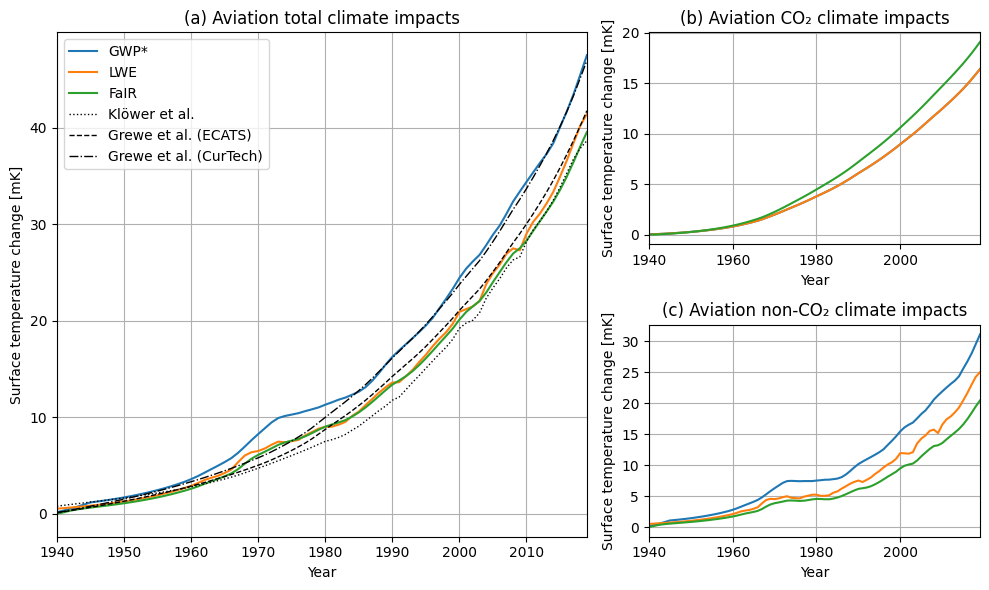

In [7]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.6, 1])

ax1 = fig.add_subplot(gs[:, 0])
ax1.plot(years_data, 1000 * gwpstar_climate_model[-1], label='GWP*')
ax1.plot(years_data, 1000 * lwe_climate_model[-1], label='LWE')
ax1.plot(years_data, 1000 * fair_climate_model[-1], label='FaIR')
ax1.plot(years_data, 1000 * data_temperature_klower[0:2019-1940+1]/1000, label='Klöwer et al.', color='black', linestyle=":", linewidth=1)
ax1.plot(years_data, 1000 * data_temperature_grewe_ecats[0:2019-1940+1]/1000, label='Grewe et al. (ECATS)', color='black', linestyle="--", linewidth=1)
ax1.plot(years_data, 1000 * data_temperature_grewe_curtech[0:2019-1940+1]/1000, label='Grewe et al. (CurTech)', color='black', linestyle="-.", linewidth=1)
ax1.legend()
ax1.grid()
ax1.set_xlim(1940, 2019)
ax1.set_xlabel('Year')
ax1.set_ylabel('Surface temperature change [mK]')
ax1.set_title("(a) Aviation total climate impacts")

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(years_data, 1000 * gwpstar_climate_model[2], label='GWP*')
ax2.plot(years_data, 1000 * lwe_climate_model[2], label='LWE')
ax2.plot(years_data, 1000 * fair_climate_model[2], label='FaIR')
ax2.grid()
ax2.set_xlim(1940, 2019)
ax2.set_xlabel('Year')
ax2.set_ylabel('Surface temperature change [mK]')
ax2.set_title('(b) Aviation CO₂ climate impacts')

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(years_data, 1000 * gwpstar_climate_model[-4], label='GWP*')
ax3.plot(years_data, 1000 * lwe_climate_model[-4], label='LWE')
ax3.plot(years_data, 1000 * fair_climate_model[-4], label='FaIR')
ax3.grid()
ax3.set_xlim(1940, 2019)
ax3.set_xlabel('Year')
ax3.set_ylabel('Surface temperature change [mK]')
ax3.set_title('(c) Aviation non-CO₂ climate impacts')

plt.tight_layout()
plt.savefig("figures/climate_model_comparison.pdf")
plt.show()